In [34]:
import numpy as np
import locale
import matplotlib.pyplot as plt
from math import floor, log10
from scipy import special, optimize
from scipy.integrate import solve_bvp, quad
from statistics import median
from enum import Enum

# Set to German locale to get comma decimal separater
locale.setlocale(locale.LC_NUMERIC, "ru_RU")
plt.rcParams.update({"font.size": 13})
params = {"text.latex.preamble": r"\usepackage{icomma}"}
plt.rcParams["axes.formatter.use_locale"] = True
plt.rcParams.update(params)

props = dict(boxstyle="square", facecolor="white")
props_note = dict(boxstyle="ellipse", facecolor="white")

eV_to_J = 1.6e-19
eV_to_K = 11604
J_to_eV = 6.242e18
eV_to_erg = 1.602e-12
erg_to_eV = 6.242e11
K_to_erg = 1.381e-16
erg_to_K = 7.243e15
Cl_to_SGS = 3.0e9


me = 9.11e-28  # electron mass
mi = 1.67e-24  # ion(proton) mass
e = 1.6e-19 * Cl_to_SGS  # electric charge of electron
a = 120.4 / K_to_erg**2 * Cl_to_SGS  # Richardson's constant
sigma = 5.67e-5 # Stefan-Boltzmann constant
phiout = 4.54 * eV_to_erg  # Pa6oma

nse = 1.0e13 # plasma component density
Te = 200.0 * eV_to_erg  # electron temperature
deltae = 0  # SEE coefficient
cs = np.sqrt(Te / mi)  # Bohm's criterion velocity
# vth = np.sqrt(8 * Te / (np.pi * me))  # Thermal electron velocity

#at T = 3000
rho = 18.22
Cp = 217.8*1.0e7/1.0e3
kappa = 21.2*1.0e6*1.0e4

r_debye = np.sqrt(Te / (4 * np.pi * nse * e**2))


def TK(T):  # dimensionless form temperature to [K]
    return T * Te * erg_to_K


def TD(T):  # [K] temperature to dimensionless form
    return T / Te * K_to_erg

In [35]:
def nte_w_func(derw, Tw, Te, nse):
    dA = -np.sign(derw) * np.sqrt(abs(derw)) * np.sqrt(e * Te / r_debye) * 300
    # print(dA * Te * erg_to_eV, phiout * erg_to_eV)
    return (
        a
        * (Tw * Te) ** 2.0
        * np.exp(-(phiout / Te + dA) / Tw)
        / (0.25 * e * nse * np.sqrt(Tw * Te * 8.0 / np.pi / me))
    )


def upsilon_0_func(phi_se, delta = 0):
    return np.sqrt(-2.0 * (phi_se))

def erfcxexp_limit_resolve(x):
    if x > 100:
        return (
            np.power(x, -0.5)
            - np.power(x, -1.5) / 2.0
            + np.power(x, -2.5) * 3.0/4.0
            - np.power(x, -3.5) * 15.0/8.0
            + np.power(x, -4.5) * 105.0/16.0
        ) / np.sqrt(np.pi)
    else:
        return special.erfc(np.sqrt(x))*np.exp(x)

In [36]:
def Poisson_integrated_classic_trans(phi, y, args):
    V_f, phi_se, n_e, Tw = y
    nse, nte_w, upsilon_0 = args
    return (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e * np.exp(phi - phi_se)
        + nte_w
        * Tw
        * (
            erfcxexp_limit_resolve((phi - (V_f + phi_se)) / Tw)
            + 2 / np.sqrt(np.pi) * np.sqrt((phi - (phi_se + V_f)) / Tw)
        )
    )


def Poisson_classic_trans(y, args):
    V_f, phi_se, n_e, Tw = y
    nse, nte_w, upsilon_0 = args
    return -2.0 * (
        Poisson_integrated_classic_trans(phi_se + V_f, y, args)
        - Poisson_integrated_classic_trans(phi_se, y, args)
    )


def quasineutrality_trans(y, args):
    V_f, phi_se, n_e, Tw = y
    nse, nte_w, upsilon_0 = args
    return 1 - nte_w * erfcxexp_limit_resolve(-V_f / Tw)- n_e


def Bohm_criterion_trans(y, args):
    V_f, phi_se, n_e, Tw = y
    nse, nte_w, upsilon_0 = args
    return phi_se + 0.5 * Tw / (
        n_e * Tw
        + nte_w
        * (
            erfcxexp_limit_resolve(-V_f / Tw)
            - 1 / (np.sqrt(np.pi) * np.sqrt(-V_f / Tw))
        )
    )


def j_wall_trans(y, args):
    V_f, phi_se, n_e, Tw = y
    nse, nte_w, upsilon_0 = args
    return V_f - np.log(
        4 * upsilon_0 / (n_e * np.sqrt(8 * mi / (np.pi * me)))
        + nte_w / n_e * np.sqrt(Tw)
    )


def sys_trans(y, *args):
    V_f, phi_se, n_e, Tw = y
    Te, nse = args
    args1 = [nse, nte_w_func(0, Tw, Te, nse), upsilon_0_func(phi_se)]
    return [
        Poisson_classic_trans(y, args1),
        j_wall_trans(y, args1),
        Bohm_criterion_trans(y, args1),
        quasineutrality_trans(y, args1),
    ]

args_trans = (Te, nse)
sol_trans_init_guesses = [
    [-1.1866, -0.591, 0.892, TD(3165)],
    [-1.1866, -0.591, 0.892, TD(2900)],
    [-1.15, -0.6, 0.9, TD(2750)],
    [-1.25, -0.6, 0.86, TD(3200)]
]

sw_trans = False
for i in range(len(sol_trans_init_guesses)):
    sol_trans = optimize.fsolve(sys_trans, sol_trans_init_guesses[i], args=args_trans) # n = 1.0e12 Te = 30eV
    print(sys_trans(sol_trans, *args_trans))
    if (np.isclose(sys_trans(sol_trans, *args_trans), np.zeros(len(sol_trans))) == np.ones(len(sol_trans), dtype = bool)).all():
        sw_trans = True
        break
     
if sw_trans == False:
    raise NameError('Appropriate sol_trans not found. Add more initial guesses')
else:
	V_f_trans, phi_se_trans, n_e_trans, Tw_trans = sol_trans
	print(
		"Transition at : Tw = ",
		f"{TK(Tw_trans):.0f}\n",
		"\tV_f_trans = ",
		V_f_trans,
		"\n\tphi_se_trans = ",
		phi_se_trans,
		"\n\tn_e_trans = ",
		n_e_trans,
	)

[np.float64(-5.7194249336589564e-11), np.float64(-7.820188940854678e-12), np.float64(2.159938894408242e-12), np.float64(-8.057998712729386e-13)]
Transition at : Tw =  3182
 	V_f_trans =  -1.1892823243971211 
	phi_se_trans =  -0.590157513885246 
	n_e_trans =  0.8924118293764327


0.039696602444902224


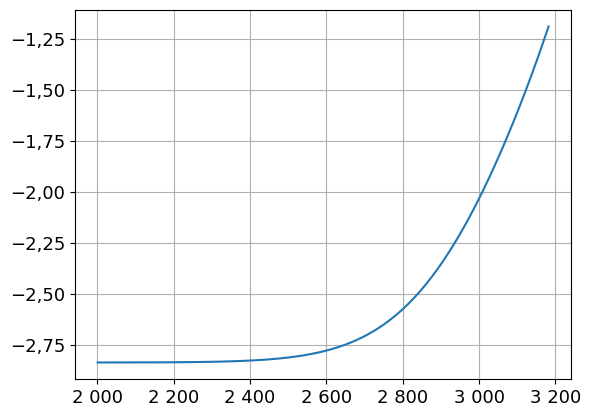

In [37]:
def j_wall_classic(y, args):
    derw, n_e, V_f, phi_se = y
    Tw, nte_w, upsilon_0, delta = args
    return V_f - np.log(
        4 * upsilon_0 / (n_e * np.sqrt(8 * mi / (np.pi * me)))
        + nte_w / n_e * np.sqrt(Tw)
    )

def Bohm_criterion_classic(y, args):
    derw, n_e, V_f, phi_se = y
    Tw, nte_w, upsilon_0, delta = args
    return phi_se + 0.5 * Tw / (
        n_e * Tw
        + nte_w
        * (
            erfcxexp_limit_resolve(-V_f / Tw)
            - 1 / (np.sqrt(np.pi) * np.sqrt(-V_f / Tw))
        )
    )


def quasineutrality_classic(y, args):
    derw, n_e, V_f, phi_se = y
    Tw, nte_w, upsilon_0, delta = args
    return 1 - nte_w * erfcxexp_limit_resolve(-V_f / Tw) - n_e


def Poisson_integrated_classic(phi, y, args):
    derw, n_e, V_f, phi_se = y
    Tw, nte_w, upsilon_0, delta = args
    return (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e * np.exp(phi - phi_se)
        + nte_w
        * Tw
        * (
            erfcxexp_limit_resolve((phi - (V_f + phi_se)) / Tw)
            + 2 / np.sqrt(np.pi) * np.sqrt((phi - (phi_se + V_f)) / Tw)
        )
    )


def Poisson_classic(y, args):
    derw, n_e, V_f, phi_se = y
    Tw, nte_w, upsilon_0, delta = args
    return derw**2 - 2.0 * (
        Poisson_integrated_classic(phi_se + V_f, y, args)
        - Poisson_integrated_classic(phi_se, y, args)
    )


def sys_classic(y, *args):
    derw, n_e, V_f, phi_se = y
    Tw, Te, nse, delta = args
    args1 = [Tw, nte_w_func(derw, Tw, Te, nse), upsilon_0_func(phi_se, delta), delta]
    return [
        quasineutrality_classic(y, args1),
        j_wall_classic(y, args1),
        Bohm_criterion_classic(y, args1),
        Poisson_classic(y, args1)
    ]

Tw_classic_net_min = TD(2000)
Tw_classic_net_max = Tw_trans
Tw_classic_net_steps = 501
Tw_classic_net = np.linspace(
    Tw_classic_net_min, Tw_classic_net_max, Tw_classic_net_steps
)
dT_classic_net = Tw_classic_net[1] - Tw_classic_net[0]

V_f_classic_net = np.zeros(Tw_classic_net_steps)
phi_se_classic_net = np.zeros(Tw_classic_net_steps)
n_e_classic_net = np.zeros(Tw_classic_net_steps)
derw_classic_net = np.zeros(Tw_classic_net_steps)
jte_classic_net = np.zeros(Tw_classic_net_steps)

for i in range(Tw_classic_net_steps - 1, -1, -1):
    Tw = Tw_classic_net[i]
    args = (Tw, Te, nse, 0.0)
    # sol_classic = optimize.fsolve(sys_classic, [0.5, 0.9, -2.0, -0.6], args=args)
    if (i >= Tw_classic_net_steps - 2):
        sol_classic = optimize.fsolve(sys_classic, [0.0, n_e_trans, V_f_trans, phi_se_trans], args=args)
    else:
        j = 0
        while (not (np.isclose(sys_classic(sol_classic, *args), np.zeros(len(sol_classic))) == np.ones(len(sol_classic), dtype = bool)).all()) and j < 10:
            j += 1
            sol_classic = optimize.fsolve(sys_classic, 
                [   
                    derw_classic_net[i + 1] + (derw_classic_net[i + 1] - derw_classic_net[i + 2]) / 5 * j,
                    n_e_classic_net[i + 1] + (n_e_classic_net[i + 1] - n_e_classic_net[i + 2]) / 5 * j, 
                    V_f_classic_net[i + 1] + (V_f_classic_net[i + 1] - V_f_classic_net[i + 2]) / 5 * j, 
                    phi_se_classic_net[i + 1] + (phi_se_classic_net[i + 1] - phi_se_classic_net[i + 2]) / 5 * j
                ], 
                args=args
            )
    derw_classic_net[i] = sol_classic[0]
    n_e_classic_net[i] = sol_classic[1]
    V_f_classic_net[i] = sol_classic[2]
    phi_se_classic_net[i] = sol_classic[3]
    # if not (np.isclose(sys_classic(sol_classic, *args), np.zeros(len(sol_classic))) == np.ones(len(sol_classic), dtype = bool)).all():
    #     print(f"{TK(Tw):.1f}(i = {i})", " : ", sys_classic(sol_classic, *args))

plt.grid()
plt.plot(TK(Tw_classic_net),V_f_classic_net)

print(erfcxexp_limit_resolve(201))

In [38]:
def jwall_SCL(y, args):
    derw, n_e_se, V_f, phi_se, V_vc = y
    Tw, nte_w, upsilon_0 = args
    dip = (V_f - V_vc) / Tw
    return (
        upsilon_0
        - 0.25 * n_e_se * np.sqrt(8 * mi / (np.pi * me)) * np.exp(V_vc)
        + 0.25 * nte_w * np.sqrt(Tw * 8 * mi / (np.pi * me)) * np.exp(-dip)
    )  #


def quasineutrality_SCL(y, args):
    derw, n_e_se, V_f, phi_se, V_vc = y
    Tw, nte_w, upsilon_0 = args
    dip = (V_f - V_vc) / Tw
    return (
        1 - n_e_se - nte_w * erfcxexp_limit_resolve(-V_vc / Tw) * np.exp(-dip)
    )  #


def Bohm_SCL(y, args):
    derw, n_e_se, V_f, phi_se, V_vc = y
    Tw, nte_w, upsilon_0 = args
    dip = (V_f - V_vc) / Tw
    return (
        -1.0 / upsilon_0**2
        + n_e_se
        + nte_w
        / Tw
        * np.exp(-dip)
        * (
            erfcxexp_limit_resolve(-V_vc / Tw)
            - 1 / np.sqrt(np.pi * (-V_vc) / Tw)
        )
    )  # ~~~


def Poisson_integrated_SCL_beta(phi, y, args):
    derw, n_e_se, V_f, phi_se, V_vc = y
    Tw, nte_w, upsilon_0 = args
    dip = (V_f - V_vc) / Tw
    return (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e_se * np.exp(phi - phi_se)
        + nte_w
        * Tw
        * np.exp(-dip)
        * (
            erfcxexp_limit_resolve((phi - (V_vc + phi_se)) / Tw)
            + 2.0
            / np.sqrt(np.pi)
            * np.sqrt((phi - (V_vc + phi_se)) / Tw)
        )
    )  # ~~~


def Poisson_SCL_beta(y, args):
    derw, n_e_se, V_f, phi_se, V_vc = y
    return -2 * (
        Poisson_integrated_SCL_beta(V_vc + phi_se, y, args)
        - Poisson_integrated_SCL_beta(phi_se, y, args)
    )

def Poisson_integrated_SCL_alpha(phi, y, args):
    derw, n_e_se, V_f, phi_se, V_vc = y
    Tw, nte_w, upsilon_0 = args
    dip = (V_f - V_vc) / Tw
    res = (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e_se
        * (
            # np.exp(V_vc) * erfcxexp_limit_resolve(phi - (V_vc + phi_se))
            np.exp(phi - phi_se) * special.erfc(np.sqrt(phi - (V_vc + phi_se)))
            + 2.0
            / np.sqrt(np.pi)
            * (np.sqrt(phi - (V_vc + phi_se)))
            * np.exp(V_vc)
        )
        + nte_w
        * Tw
        * (
            np.exp((phi - (V_f + phi_se))/Tw) * (1 + special.erf(np.sqrt((phi - (V_vc + phi_se)) / Tw)))
            - 2.0
            / np.sqrt(np.pi)
            * (np.sqrt((phi - (V_vc + phi_se))/Tw))
            * np.exp((V_vc - V_f)/Tw)
        )
    )
    return res

def Poisson_SCL_alpha(y, args):
    derw, n_e_se, V_f, phi_se, V_vc = y
    Tw, Te, nse = args
    return derw**2 - 2 * (
        Poisson_integrated_SCL_alpha(V_f + phi_se, y, args)
        - Poisson_integrated_SCL_alpha(V_vc + phi_se, y, args)
    )

def sys_SCL(y, *args):
    derw, n_e_se, V_f, phi_se, V_vc = y
    Tw, Te, nse = args
    nte_w = nte_w_func(derw, Tw, Te, nse)
    upsilon_0 = upsilon_0_func(phi_se)
    args1 = [Tw, nte_w, upsilon_0]
    return [
        quasineutrality_SCL(y, args1),
        jwall_SCL(y, args1),
        Bohm_SCL(y, args1),
        Poisson_SCL_alpha(y, args1),
        Poisson_SCL_beta(y, args1),
    ]

Tw_SCL_net_max = TD(3695)
Tw_SCL_net_min = Tw_trans
Tw_SCL_net_steps = 101
Tw_SCL_net = np.linspace(Tw_SCL_net_min, Tw_SCL_net_max, Tw_SCL_net_steps)

V_f_SCL_net = np.zeros(Tw_SCL_net_steps)
phi_se_SCL_net = np.zeros(Tw_SCL_net_steps)
V_vc_SCL_net = np.zeros(Tw_SCL_net_steps)
n_e_SCL_net = np.zeros(Tw_SCL_net_steps)
derw_SCL_net = np.zeros(Tw_SCL_net_steps)

for i in range(Tw_SCL_net_steps):
    Tw = Tw_SCL_net[i]
    args = (Tw, Te, nse)
    if i == 0:
        sol_SCL = optimize.fsolve(
            sys_SCL,
            [
                derw_classic_net[-1],
                n_e_classic_net[-1],
                V_f_classic_net[-1],
                phi_se_classic_net[-1],
                V_f_classic_net[-1],
            ],
            args=args,
        )
    else:
        sol_SCL = optimize.fsolve(
            sys_SCL,
            [
                derw_SCL_net[i-1] - 0.05,
                n_e_SCL_net[i-1],
                V_f_SCL_net[i-1] + 0.00005, # 0.0001 works for Te <= 150 eV, 0.00005 - for higher Te 
                phi_se_SCL_net[i-1],
                V_vc_SCL_net[i-1],
            ],
            args=args,
        )
    derw_SCL_net[i] = sol_SCL[0]
    n_e_SCL_net[i] = sol_SCL[1]
    V_f_SCL_net[i] = sol_SCL[2]
    phi_se_SCL_net[i] = sol_SCL[3]
    V_vc_SCL_net[i] = sol_SCL[4]
    # if not (np.isclose(sys_SCL(sol_SCL, *args), np.zeros(len(sol_SCL))) == np.ones(len(sol_SCL), dtype = bool)).all():
    #     print(f"{TK(Tw):.1f}", " : ", sys_SCL(sol_SCL, *args))
    #     True

C:\Users\popac\AppData\Local\Temp\ipykernel_17964\1367458783.py:73: RuntimeWarning: invalid value encountered in sqrt
  np.exp(phi - phi_se) * special.erfc(np.sqrt(phi - (V_vc + phi_se)))
C:\Users\popac\AppData\Local\Temp\ipykernel_17964\1367458783.py:76: RuntimeWarning: invalid value encountered in sqrt
  * (np.sqrt(phi - (V_vc + phi_se)))
C:\Users\popac\AppData\Local\Temp\ipykernel_17964\1367458783.py:82: RuntimeWarning: invalid value encountered in sqrt
  np.exp((phi - (V_f + phi_se))/Tw) * (1 + special.erf(np.sqrt((phi - (V_vc + phi_se)) / Tw)))
C:\Users\popac\AppData\Local\Temp\ipykernel_17964\1367458783.py:85: RuntimeWarning: invalid value encountered in sqrt
  * (np.sqrt((phi - (V_vc + phi_se))/Tw))
C:\Users\popac\AppData\Local\Temp\ipykernel_17964\1367458783.py:128: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol_SCL = optimize.fsolve(


In [39]:
def q_ion_func(y, Tw_net, Tw_trans, is_MW = False):
    derw_net, V_f_net, phi_se_net, n_e_net, V_vc_net = y
    q_net = np.zeros(len(Tw_net))
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        q_net[i] = upsilon_0 * (upsilon_0**2 / 2 - V_vc_net[i])
        if (is_MW == True) :
            q_net[i] = q_net[i] * nse * cs * Te * 1.0e6 * 1.0e-2 * 1.0e-7 * 1.0e-6
    return q_net

def q_e_func(y, Tw_net, Tw_trans, is_MW = False):
    derw_net, V_f_net, phi_se_net, n_e_net, V_vc_net = y
    q_net = np.zeros(len(Tw_net))
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        if (Tw_net[i] <= Tw_trans):
            q_net[i] = (
                0.25 * n_e_net[i] * vth * (2) * np.exp(V_f_net[i])
            )
        else:
            q_net[i] = (
                0.25 * n_e_net[i] * vth * (2) * np.exp(V_vc_net[i])
            )
        if (is_MW == True) :
            q_net[i] = q_net[i] * nse * cs * Te * 1.0e6 * 1.0e-2 * 1.0e-7 * 1.0e-6
    return q_net

def q_te_func(y, Tw_net, Tw_trans, is_MW = False):
    derw_net, V_f_net, phi_se_net, n_e_net, V_vc_net = y
    q_net = np.zeros(len(Tw_net))
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        if (Tw_net[i] <= Tw_trans):
            q_net[i] = (
                - 0.25 * nte_w_func(derw_net[i], Tw_net[i], Te, nse) * vteth * 2 * Tw_net[i]
            )
        else:
            q_net[i] = (
                - 0.25 * nte_w_func(derw_net[i], Tw_net[i], Te, nse) * vteth * 2 * Tw_net[i] * np.exp((V_vc_net[i] - V_f_net[i])/Tw)#special.erfc(np.sqrt((V_f_net[i] - V_vc_net[i]) / Tw_net[i]))
            )
        if (is_MW == True) :
            q_net[i] = q_net[i] * nse * cs * Te * 1.0e6 * 1.0e-2 * 1.0e-7 * 1.0e-6
    return q_net

def q_bb_func(y, Tw_net, Tw_trans, is_MW = False):
    derw_net, V_f_net, phi_se_net, n_e_net, V_vc_net = y
    q_net = np.zeros(len(Tw_net))
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        q_net[i] = -sigma * (Tw_net[i]*Te)**4 / (nse * cs * Te)
        if (is_MW == True) :
            q_net[i] = q_net[i] * nse * cs * Te * 1.0e6 * 1.0e-2 * 1.0e-7 * 1.0e-6
    return q_net


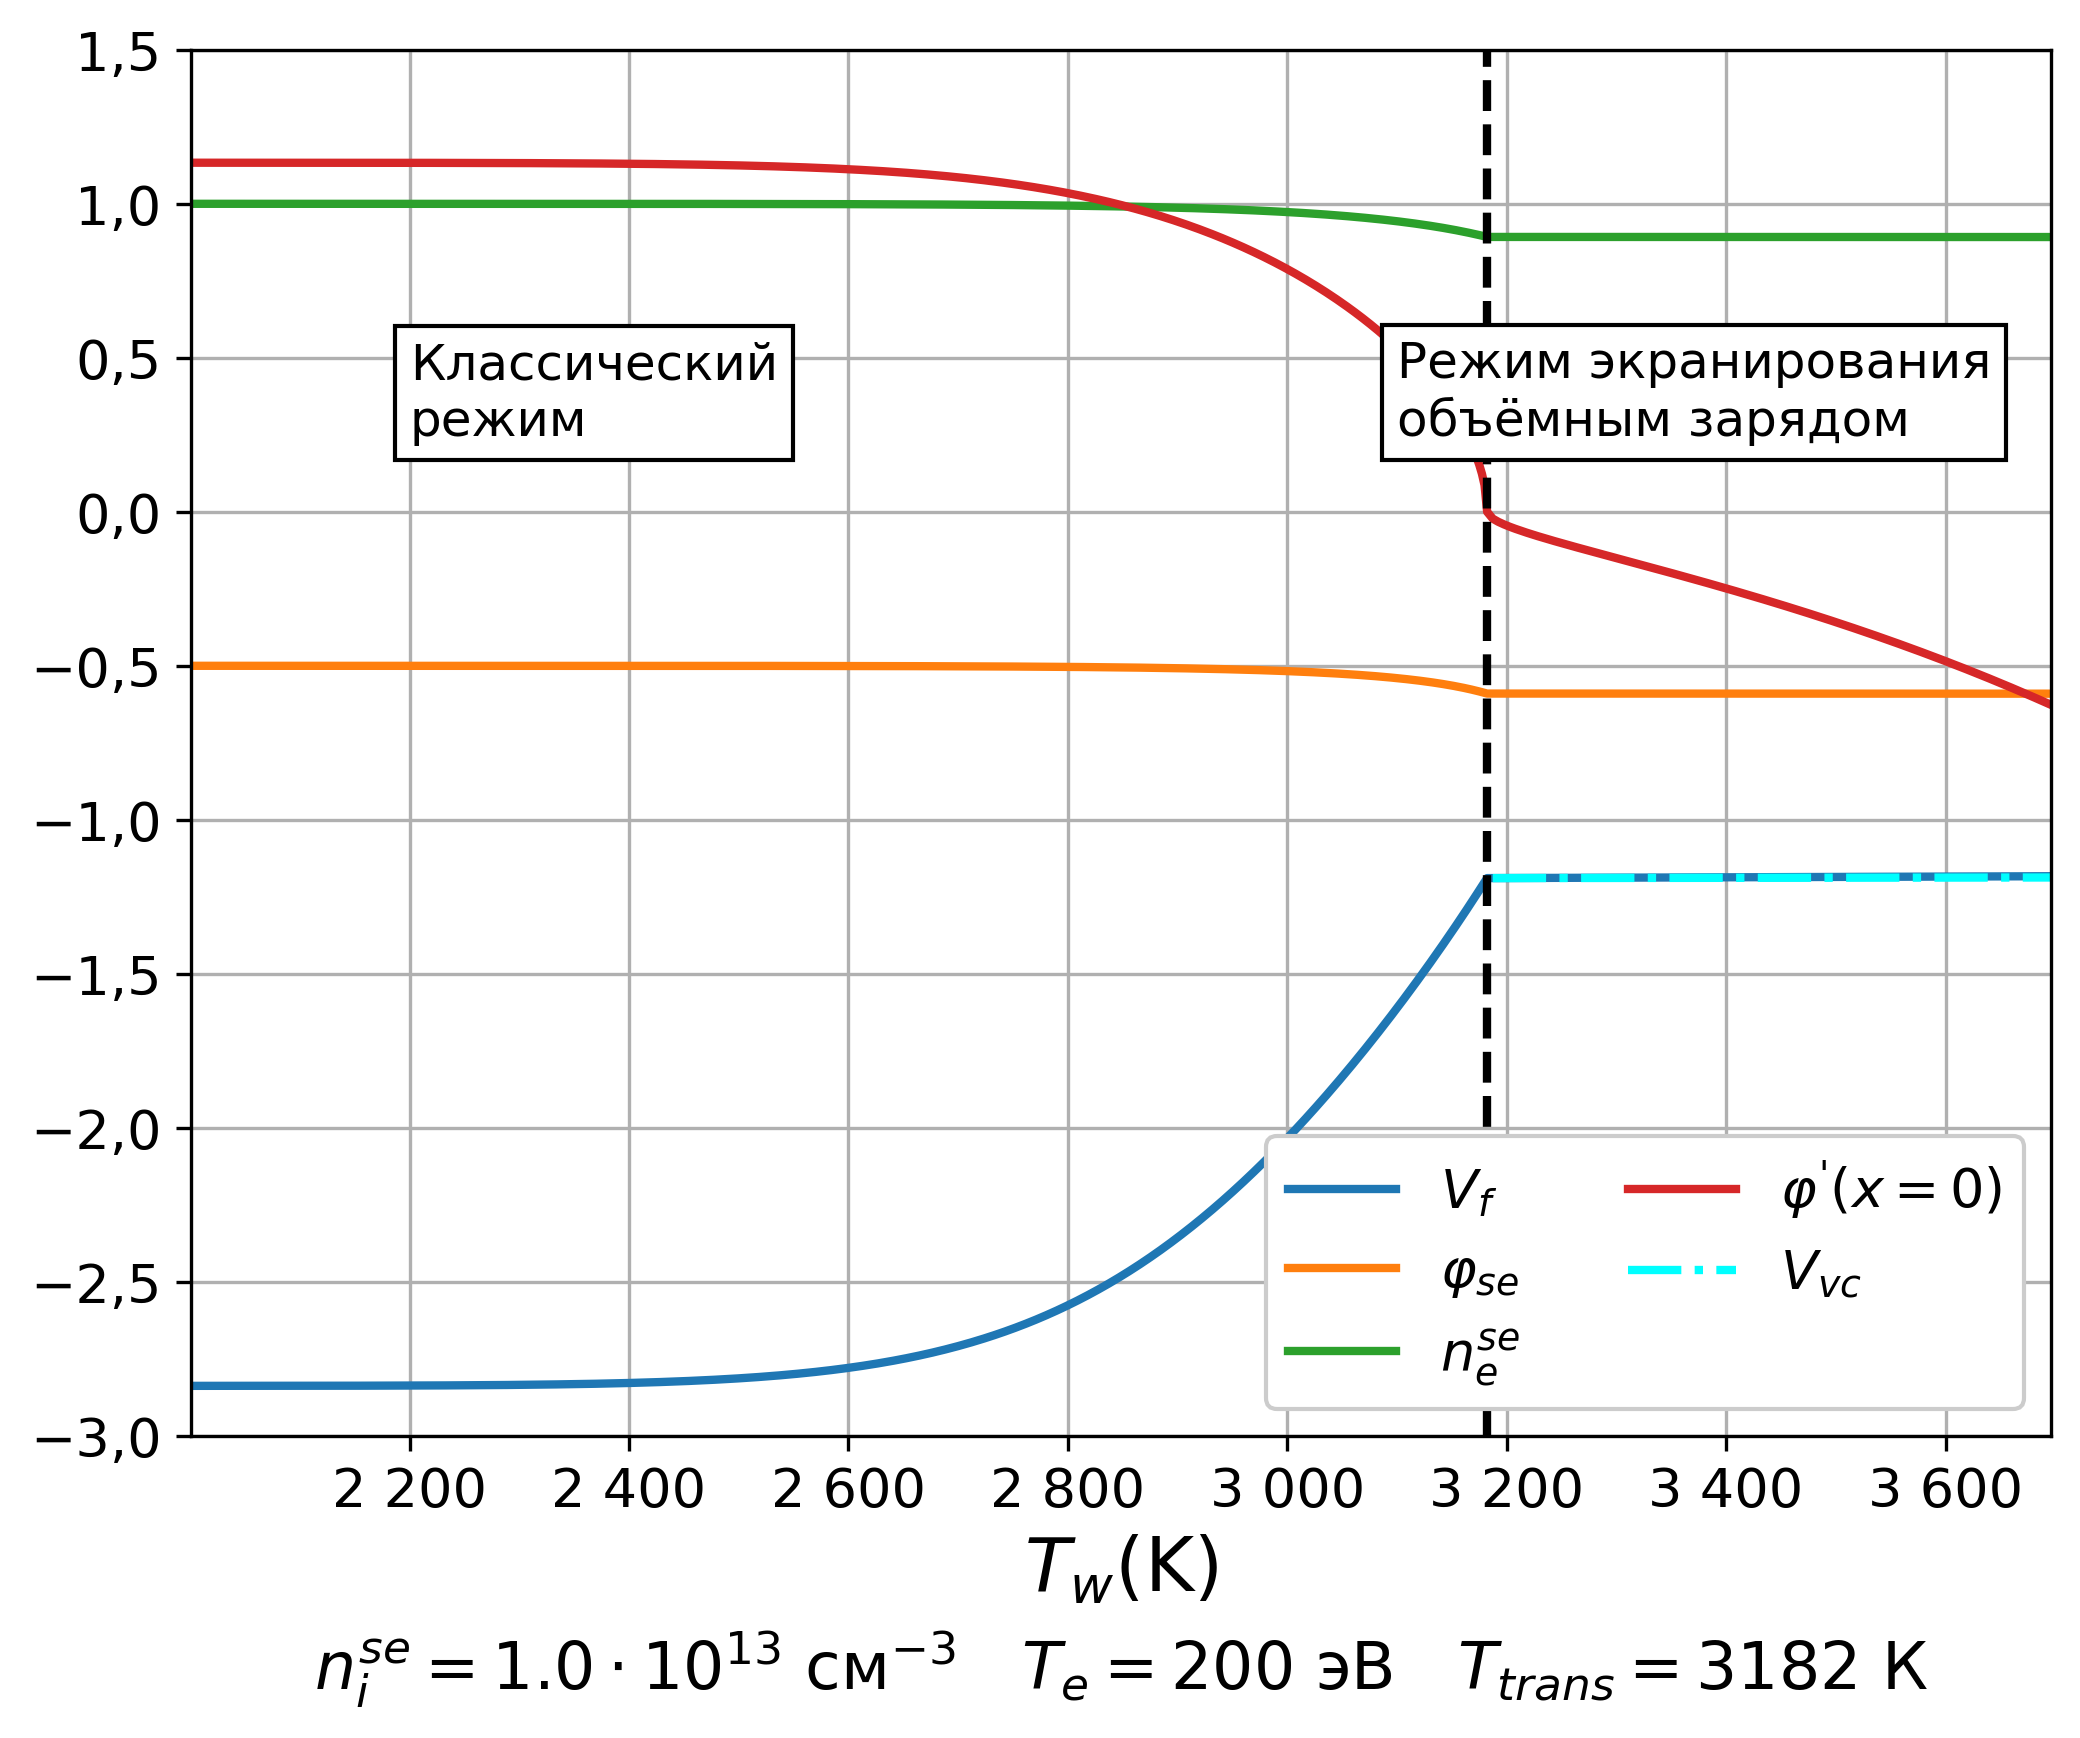

In [40]:
Tw_all_net = np.concatenate((Tw_classic_net, Tw_SCL_net[1:]))
Tw_all_net_plot = [0] * len(Tw_all_net)
for i in range(len(Tw_all_net)):
	Tw_all_net_plot[i] = TK(Tw_all_net[i])

V_f_all_net = np.concatenate((V_f_classic_net, V_f_SCL_net[1:]))
V_vc_all_net = np.concatenate((V_f_classic_net, V_vc_SCL_net[1:]))
derw_all_net = np.concatenate((derw_classic_net, derw_SCL_net[1:]))
n_e_all_net = np.concatenate((n_e_classic_net, n_e_SCL_net[1:]))
phi_se_all_net = np.concatenate((phi_se_classic_net, phi_se_SCL_net[1:]))

fig = plt.figure(figsize=(8, 6), dpi=300)

plt.plot(Tw_all_net_plot, V_f_all_net, lw=2, label=r"$V_f$")
plt.plot(Tw_all_net_plot, phi_se_all_net, lw=2, label=r"$\varphi_{se}$")
plt.plot(Tw_all_net_plot, n_e_all_net, lw=2, label=r"$n_e^{se}$")
plt.plot(Tw_all_net_plot, derw_all_net, lw=2, label=r"$\varphi^'(x = 0)$")
plt.plot(Tw_all_net_plot[Tw_classic_net_steps:], V_vc_SCL_net[1:], lw=2, label=r"$V_{vc}$", color = 'cyan', linestyle = '-.')

plt.text(
    # (min(Tw_all_net_plot) + TK(Tw_trans)) / 2 - 300,
	2200,
    (n_e_all_net[0] + phi_se_all_net[0])/2,
    r"Классический"
    "\n"
    r"режим",
    fontsize=12,
    bbox=props,
)

plt.text(
    # TK(Tw_trans) + 100,
	3100,
    (n_e_all_net[0] + phi_se_all_net[0])/2,
    r"Режим экранирования"
    "\n"
    r"объёмным зарядом",
    fontsize=12,
    bbox=props,
)

plt.xlim(min(Tw_all_net_plot), max(Tw_all_net_plot))
plt.ylim(-3.0, 1.5)
plt.plot((TK(Tw_trans), TK(Tw_trans)), (-3.0, 1.5), lw = 2, color = 'k', scaley=False, linestyle = 'dashed')
plt.legend(loc = 'lower right', ncols=2, framealpha = 1)
plt.grid()
plt.title(r"$n_i^{se} = %.1f\cdot10^{%d}$ см$^{-3}$   "
    r"$T_e = %0.f$ эВ   "
    r"$T_{trans} = %0.f$ К"
    % (nse / 10 ** floor(log10(nse)), floor(log10(nse)), Te * erg_to_eV, TK(Tw_trans)),
	y = -0.2)
plt.xlabel(r"$T_w$(K)", fontdict = dict(fontsize = 18))
plt.show()

Text(0.5, -0.2, '$n_i^{se} = 1.0\\cdot10^{13}$ см$^{-3}$   $T_e = 200$ эВ   $T_{trans} = 3182$ К')

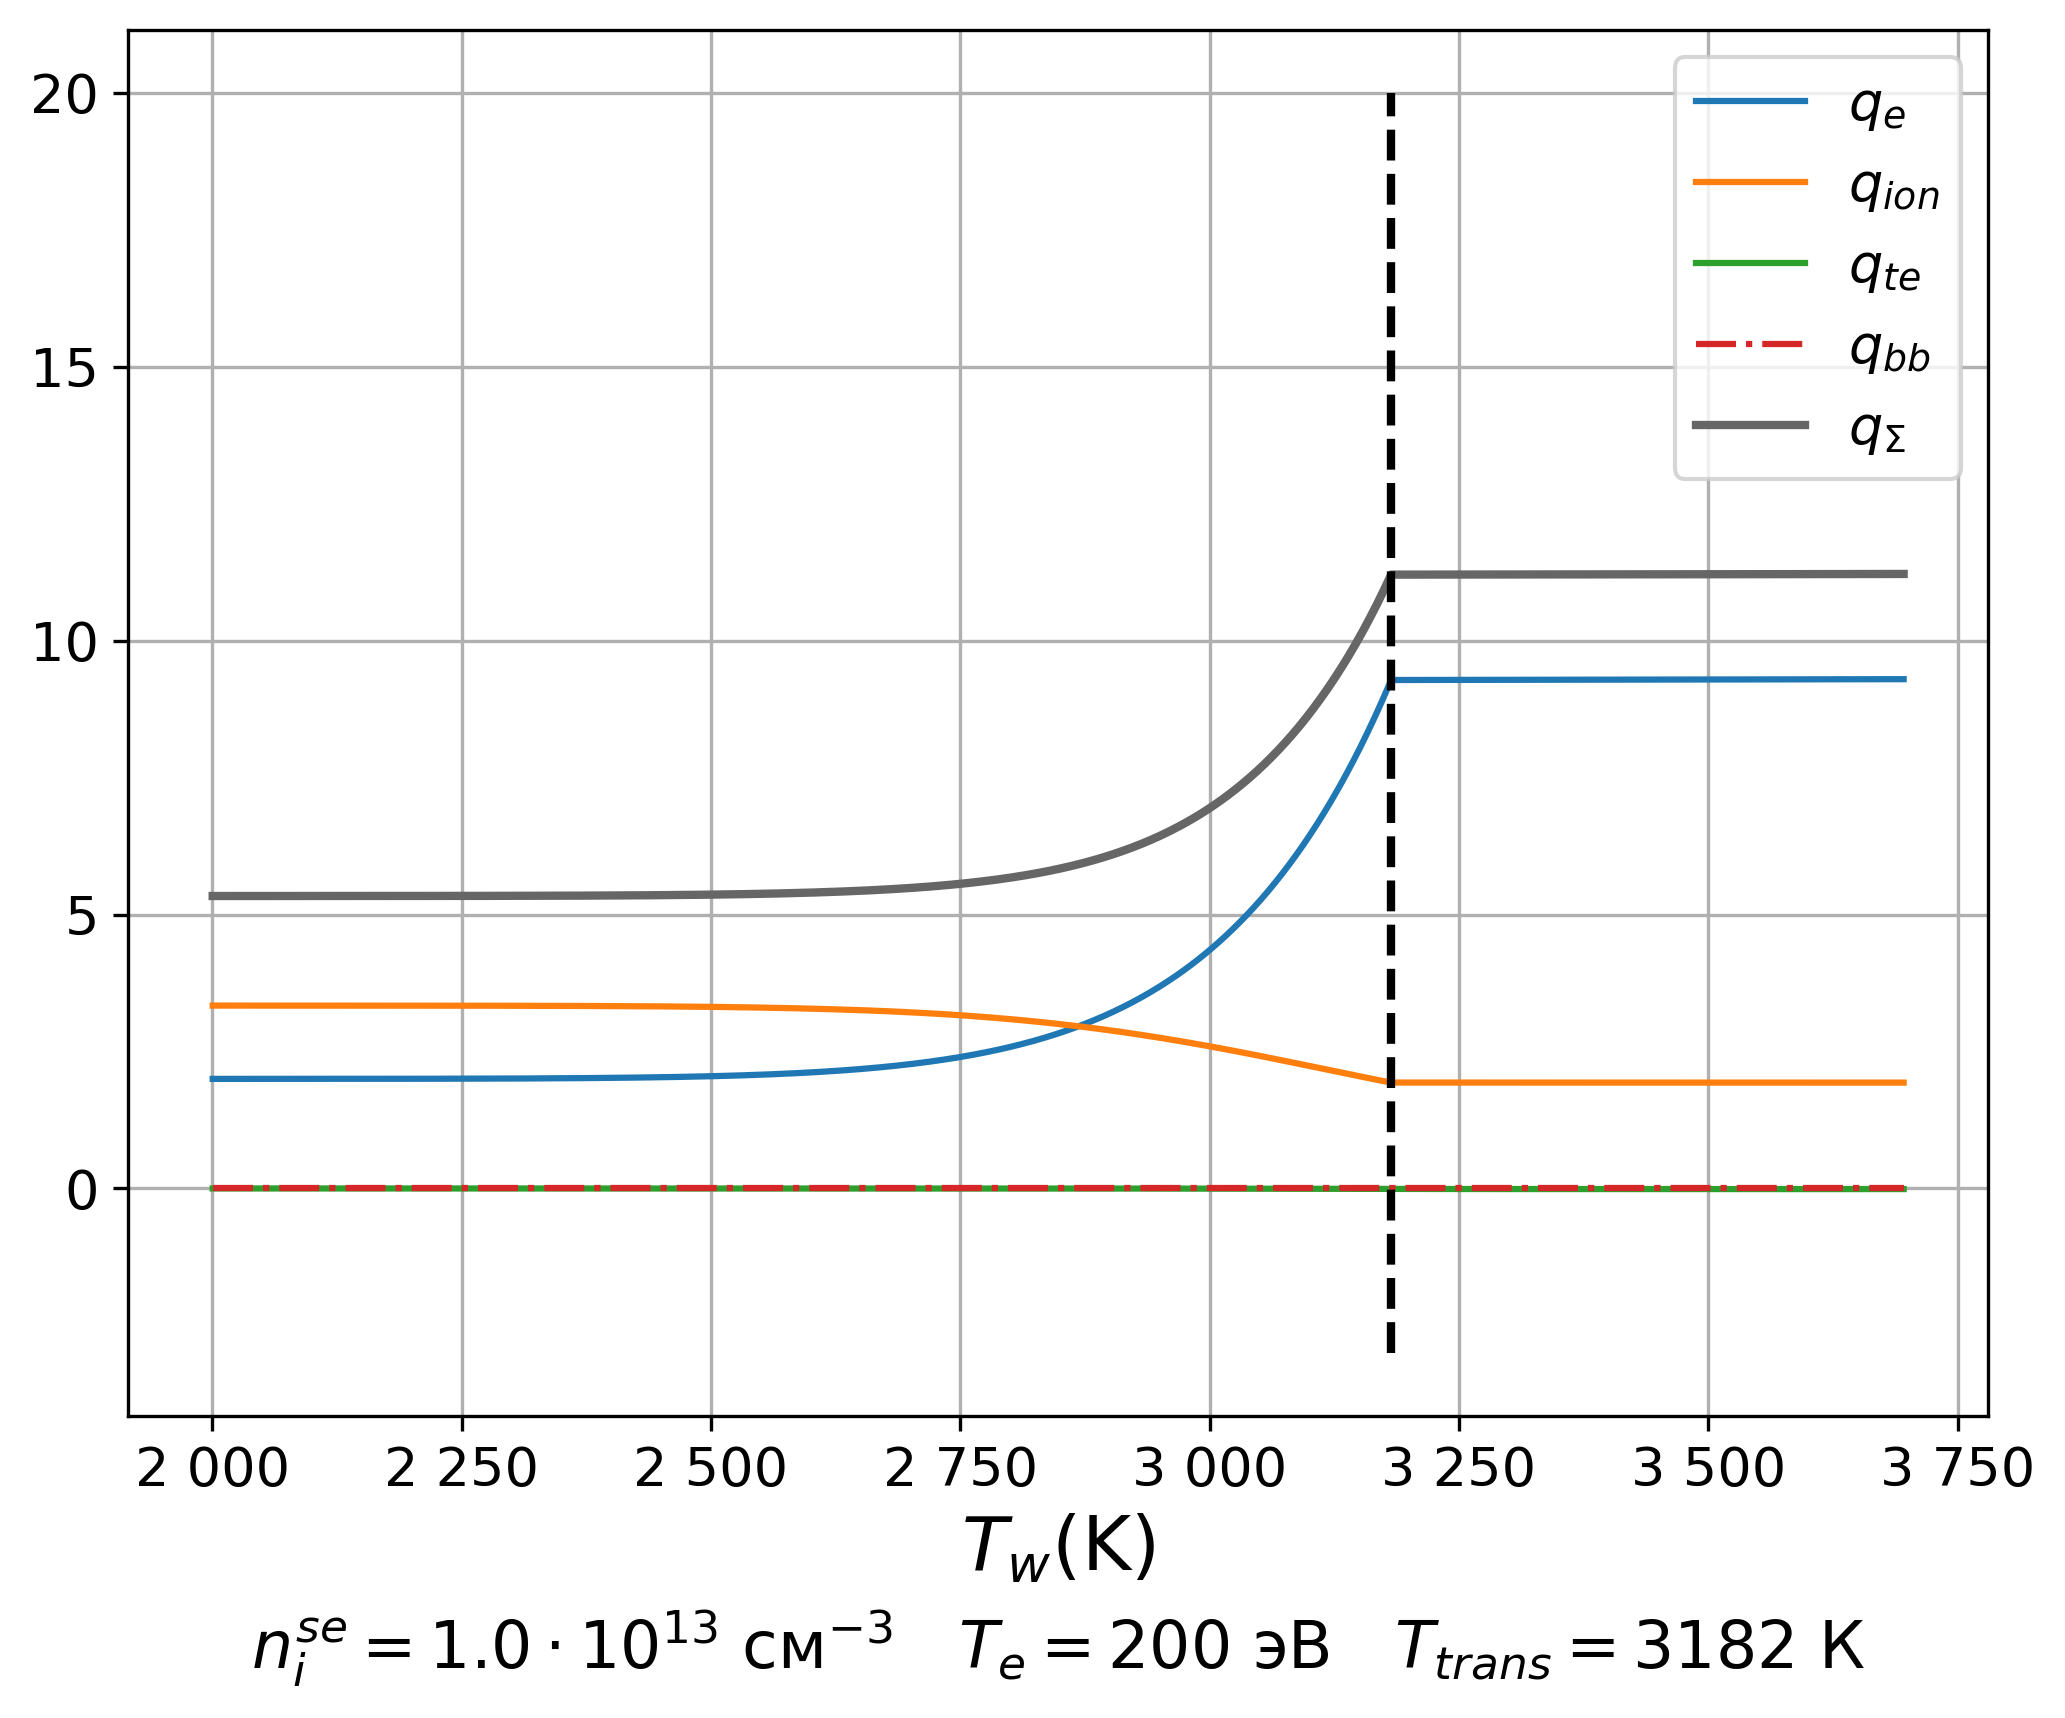

In [41]:
q_e_net = q_e_func([derw_all_net, V_f_all_net, phi_se_all_net, n_e_all_net, V_vc_all_net], Tw_all_net, Tw_trans)
q_ion_net = q_ion_func([derw_all_net, V_f_all_net, phi_se_all_net, n_e_all_net, V_vc_all_net], Tw_all_net, Tw_trans)
q_te_net = q_te_func([derw_all_net, V_f_all_net, phi_se_all_net, n_e_all_net, V_vc_all_net], Tw_all_net, Tw_trans)
q_bb_net = q_bb_func([derw_all_net, V_f_all_net, phi_se_all_net, n_e_all_net, V_vc_all_net], Tw_all_net, Tw_trans)
fig = plt.figure(figsize=(8, 6), dpi=300)
plt.plot(Tw_all_net_plot, q_e_net, label = r"$q_e$")
plt.plot(Tw_all_net_plot, q_ion_net, label = r"$q_{ion}$")
plt.plot(Tw_all_net_plot, q_te_net, label = r"$q_{te}$")
plt.plot(Tw_all_net_plot, q_bb_net, label = r"$q_{bb}$", linestyle = "-.")
plt.plot(Tw_all_net_plot, q_e_net + q_ion_net + q_te_net + q_bb_net, lw = 2, color = '#666666', label = r"$q_\Sigma$")
plt.plot((TK(Tw_trans), TK(Tw_trans)), (-3.0, 20), lw = 2, color = 'k', scaley=False, linestyle = 'dashed')
plt.grid(which='both')
plt.xlabel(r"$T_w$(K)", fontdict = dict(fontsize = 18))
plt.legend()
plt.title(r"$n_i^{se} = %.1f\cdot10^{%d}$ см$^{-3}$   "
    r"$T_e = %0.f$ эВ   "
    r"$T_{trans} = %0.f$ К"
    % (nse / 10 ** floor(log10(nse)), floor(log10(nse)), Te * erg_to_eV, TK(Tw_trans)),
	y = -0.2)

Text(0.5, -0.2, '$n_i^{se} = 1.0\\cdot10^{13}$ см$^{-3}$   $T_e = 200$ эВ   $T_{trans} = 3182$ К')

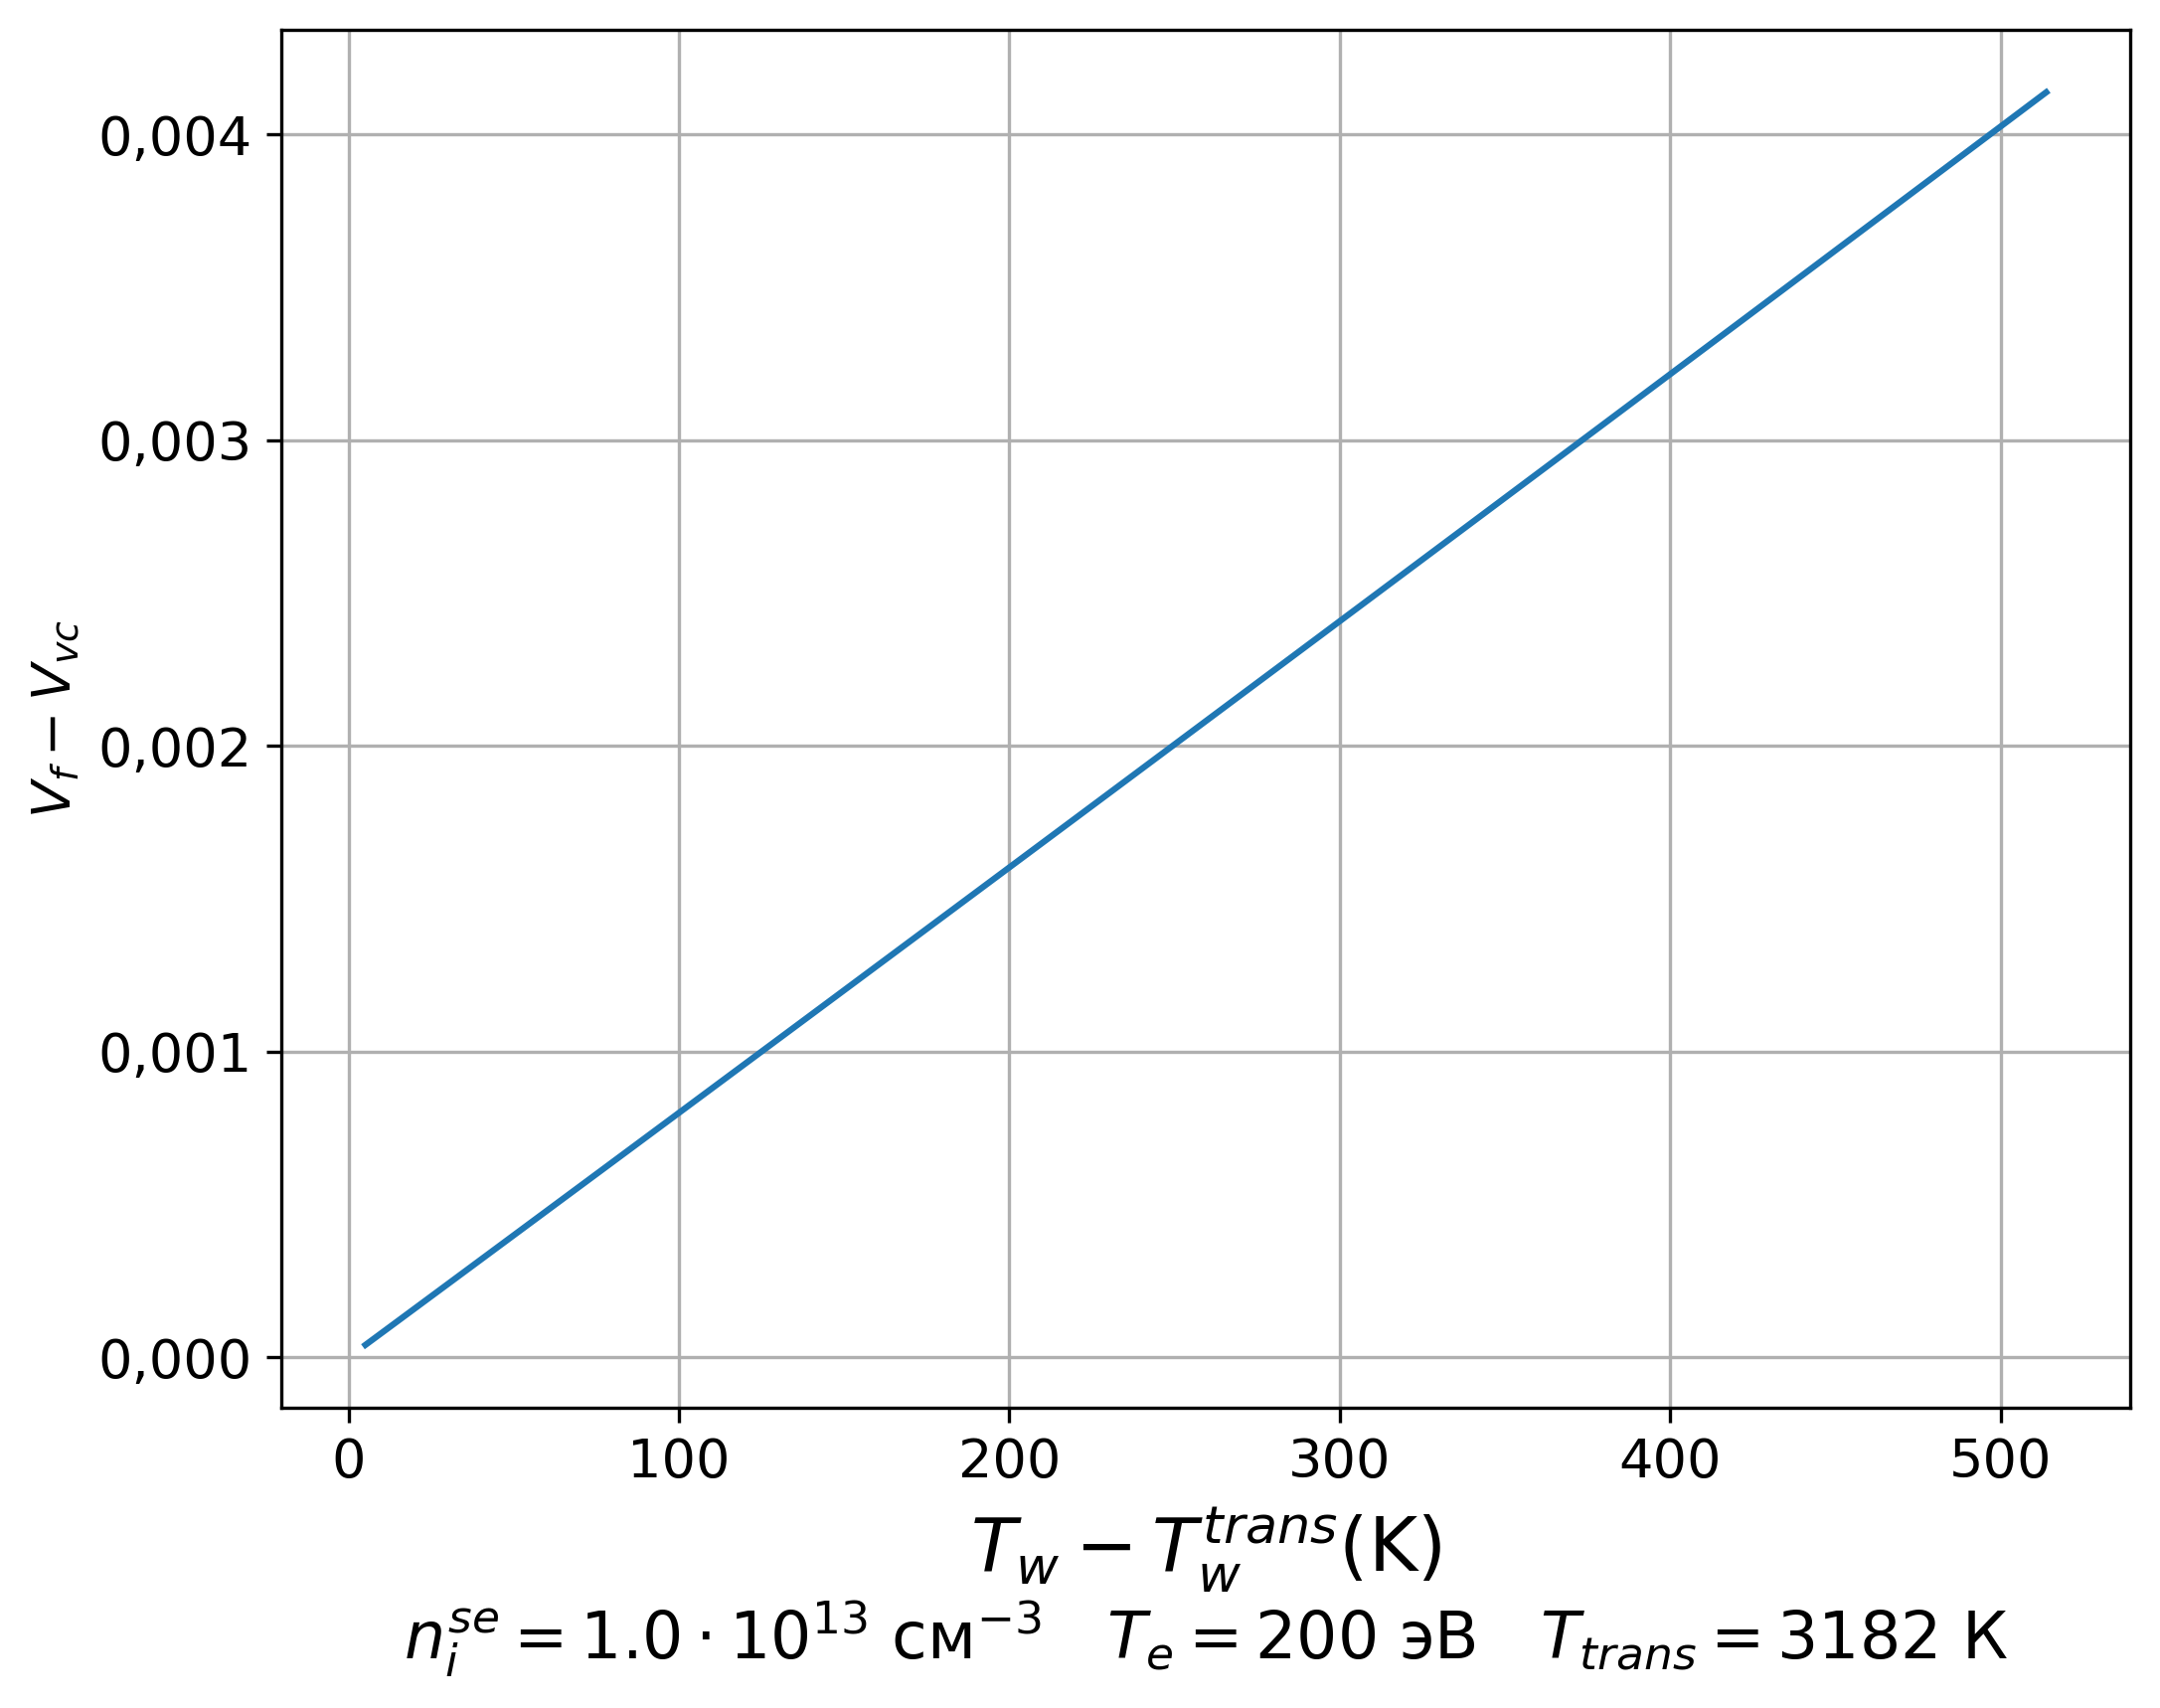

In [42]:
fig = plt.figure(figsize=(8, 6), dpi=300)
plt.plot(Tw_all_net_plot[Tw_classic_net_steps:] - TK(np.full(Tw_SCL_net_steps - 1, Tw_trans)), V_f_SCL_net[1:] - V_vc_SCL_net[1:])
plt.ylabel(r"$V_f - V_{vc}$")
plt.xlabel(r"$T_w - T_w^{trans}$(K)", fontdict = dict(fontsize = 18))
plt.grid()
plt.title(r"$n_i^{se} = %.1f\cdot10^{%d}$ см$^{-3}$   "
    r"$T_e = %0.f$ эВ   "
    r"$T_{trans} = %0.f$ К"
    % (nse / 10 ** floor(log10(nse)), floor(log10(nse)), Te * erg_to_eV, TK(Tw_trans)),
	y = -0.2)

In [43]:
def n_e_func(E_field, args):
	derw, n_e_se, V_f, phi_se, V_vc, Tw, nte_w, upsilon_0 = args
	phi = E_field[0]
	res = np.zeros(np.shape(E_field)[1])
	for i in range(np.shape(E_field)[1]):
		if E_field[1, i] < 0:
			res[i] = n_e_se * np.exp(phi[i] - phi_se) * special.erfc(np.sqrt(phi[i] - (V_vc + phi_se)))
		else:
			res[i] = n_e_se * np.exp(phi[i] - phi_se)
	return res

def n_i_func(phi, args):
	derw, n_e_se, V_f, phi_se, V_vc, Tw, nte_w, upsilon_0 = args
	res = np.zeros(np.shape(phi)[0])
	for i in range(np.shape(phi)[0]):
		if (phi[i] > 0):
			res[i] = 0
		else:
			res[i] = 1 / np.sqrt(1 - 2 * (phi[i] - phi_se) / upsilon_0**2)
	return res
	
def n_te_func(E_field, args):
	derw, n_e_se, V_f, phi_se, V_vc, Tw, nte_w, upsilon_0 = args
	phi = E_field[0]
	res = np.zeros(np.shape(E_field)[1])
	for i in range(np.shape(E_field)[1]):
		if E_field[1, i] < 0:
			res[i] = (
				nte_w
				* np.exp((phi[i] - (V_f + phi_se)) / Tw) 
				* (1 + special.erf(np.sqrt((phi[i] - (V_vc + phi_se)) / Tw)))
			)
		else:
			if ((phi[i] - (V_vc + phi_se)) / Tw) < 100:
				res[i] = (
					nte_w
					* np.exp((phi[i] - (V_f + phi_se)) / Tw) 
					* special.erfc(np.sqrt((phi[i] - (V_vc + phi_se)) / Tw))
				)
			else:
				res[i] = (
					nte_w
					* erfcxexp_limit_resolve((phi[i] - (V_vc + phi_se)) / Tw)
					* np.exp((V_vc - V_f) / Tw)
				)
	return res

def pois_eq(x, E_field, args):
	derw, n_e_se, V_f, phi_se, V_vc, Tw, nte_w, upsilon_0 = args
	return [
		E_field[1],
		-(
			n_i_func(E_field[0], args)
			- n_e_func(E_field, args)
			- n_te_func(E_field, args)
		),
	]

def pois_bc(E_field_a, E_field_b, args):
	derw, n_e_se, V_f, phi_se, V_vc, Tw, nte_w, upsilon_0 = args
	return np.array([
		E_field_b[1],
		E_field_a[0] - (phi_se + V_f)
	])

def SCL_distribution_sys(x_net_plot, y, E_field_guess, *args):
	derw, n_e_se, V_f, phi_se, V_vc = y
	Tw, Te, nse, xmax_rigorous, xmax_sparse, x_net_steps_rigorous, x_net_steps_sparse = args
	nte_w = nte_w_func(derw, Tw, Te, nse)
	upsilon_0 = upsilon_0_func(phi_se)

	x_net_rigorous = np.linspace(0, xmax_rigorous, x_net_steps_rigorous)
	x_net_sparse = np.linspace(xmax_rigorous, xmax_sparse, x_net_steps_sparse)
	x_net = np.concatenate((x_net_rigorous, x_net_sparse[1:]))
	x_net_steps = np.shape(x_net)[0]
	pois_args = [derw, n_e_se, V_f, phi_se, V_vc, Tw, nte_w, upsilon_0]
	sol = solve_bvp(
		lambda x_net, E_field_guess: pois_eq(x_net, E_field_guess, pois_args),
		lambda x_net, E_field_guess: pois_bc(x_net, E_field_guess, pois_args),
		x_net,
		E_field_guess,
		bc_tol = 1.0e-3
	)
	msg = sol.message
	print(msg)

	E_field_guess = sol.sol(x_net)
	E_field_guess[0, x_net_steps - x_net_steps // 10:] = E_field_guess[0, x_net_steps - x_net_steps // 10] # enormous values at the end of the net
	E_field_guess[1, x_net_steps - x_net_steps // 10:] = E_field_guess[1, x_net_steps - x_net_steps // 10]

	y_net = np.zeros((5, x_net_plot_steps))
	y_net[0] = sol.sol(x_net_plot)[0]
	y_net[1] = sol.sol(x_net_plot)[1]
	y_net[2] = n_e_func(y_net[0:2], pois_args)
	y_net[3] = n_i_func(y_net[0], pois_args)
	y_net[4] = n_te_func(y_net[0:2], pois_args)
	return E_field_guess, y_net

xmax_rigorous = 0.05	# estimated location of vc
x_net_steps_rigorous = 801
xmax_sparse = 50
x_net_steps_sparse = 201

xmax_plot = 10
x_net_plot_steps = 501
x_net_plot = np.linspace(0, xmax_plot, x_net_plot_steps)

E_field_guess = np.zeros((2, x_net_steps_rigorous + x_net_steps_sparse - 1))
E_field_guess[0, :] = 1.1 * phi_se_SCL_net[0]
E_field_guess[1, :] = 0.01
SCL_dist_plot_num = 0
for i in range(Tw_SCL_net_steps):
	args = (Tw_SCL_net[i], Te, nse, xmax_rigorous, xmax_sparse, x_net_steps_rigorous, x_net_steps_sparse)
	y = [
		derw_SCL_net[i],
		n_e_SCL_net[i],
		V_f_SCL_net[i],
		phi_se_SCL_net[i],
		V_vc_SCL_net[i]
	]
	SCL_dist = np.zeros((5, x_net_plot_steps))
	E_field_guess, SCL_dist = SCL_distribution_sys(x_net_plot, y, E_field_guess, *args)
	if i == SCL_dist_plot_num:
		SCL_dist_plot = SCL_dist
		break

The maximum number of mesh nodes is exceeded.


C:\Users\popac\AppData\Local\Temp\ipykernel_17964\2563004394.py:7: RuntimeWarning: invalid value encountered in sqrt
  res[i] = n_e_se * np.exp(phi[i] - phi_se) * special.erfc(np.sqrt(phi[i] - (V_vc + phi_se)))
C:\Users\popac\AppData\Local\Temp\ipykernel_17964\2563004394.py:31: RuntimeWarning: invalid value encountered in sqrt
  * (1 + special.erf(np.sqrt((phi[i] - (V_vc + phi_se)) / Tw)))
C:\Users\popac\AppData\Local\Temp\ipykernel_17964\2563004394.py:38: RuntimeWarning: invalid value encountered in sqrt
  * special.erfc(np.sqrt((phi[i] - (V_vc + phi_se)) / Tw))


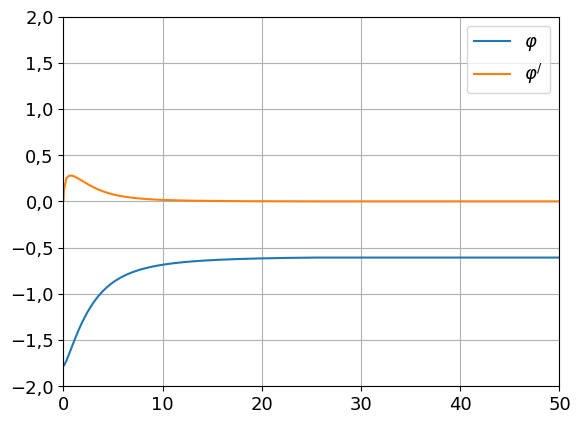

0.007768206153400731


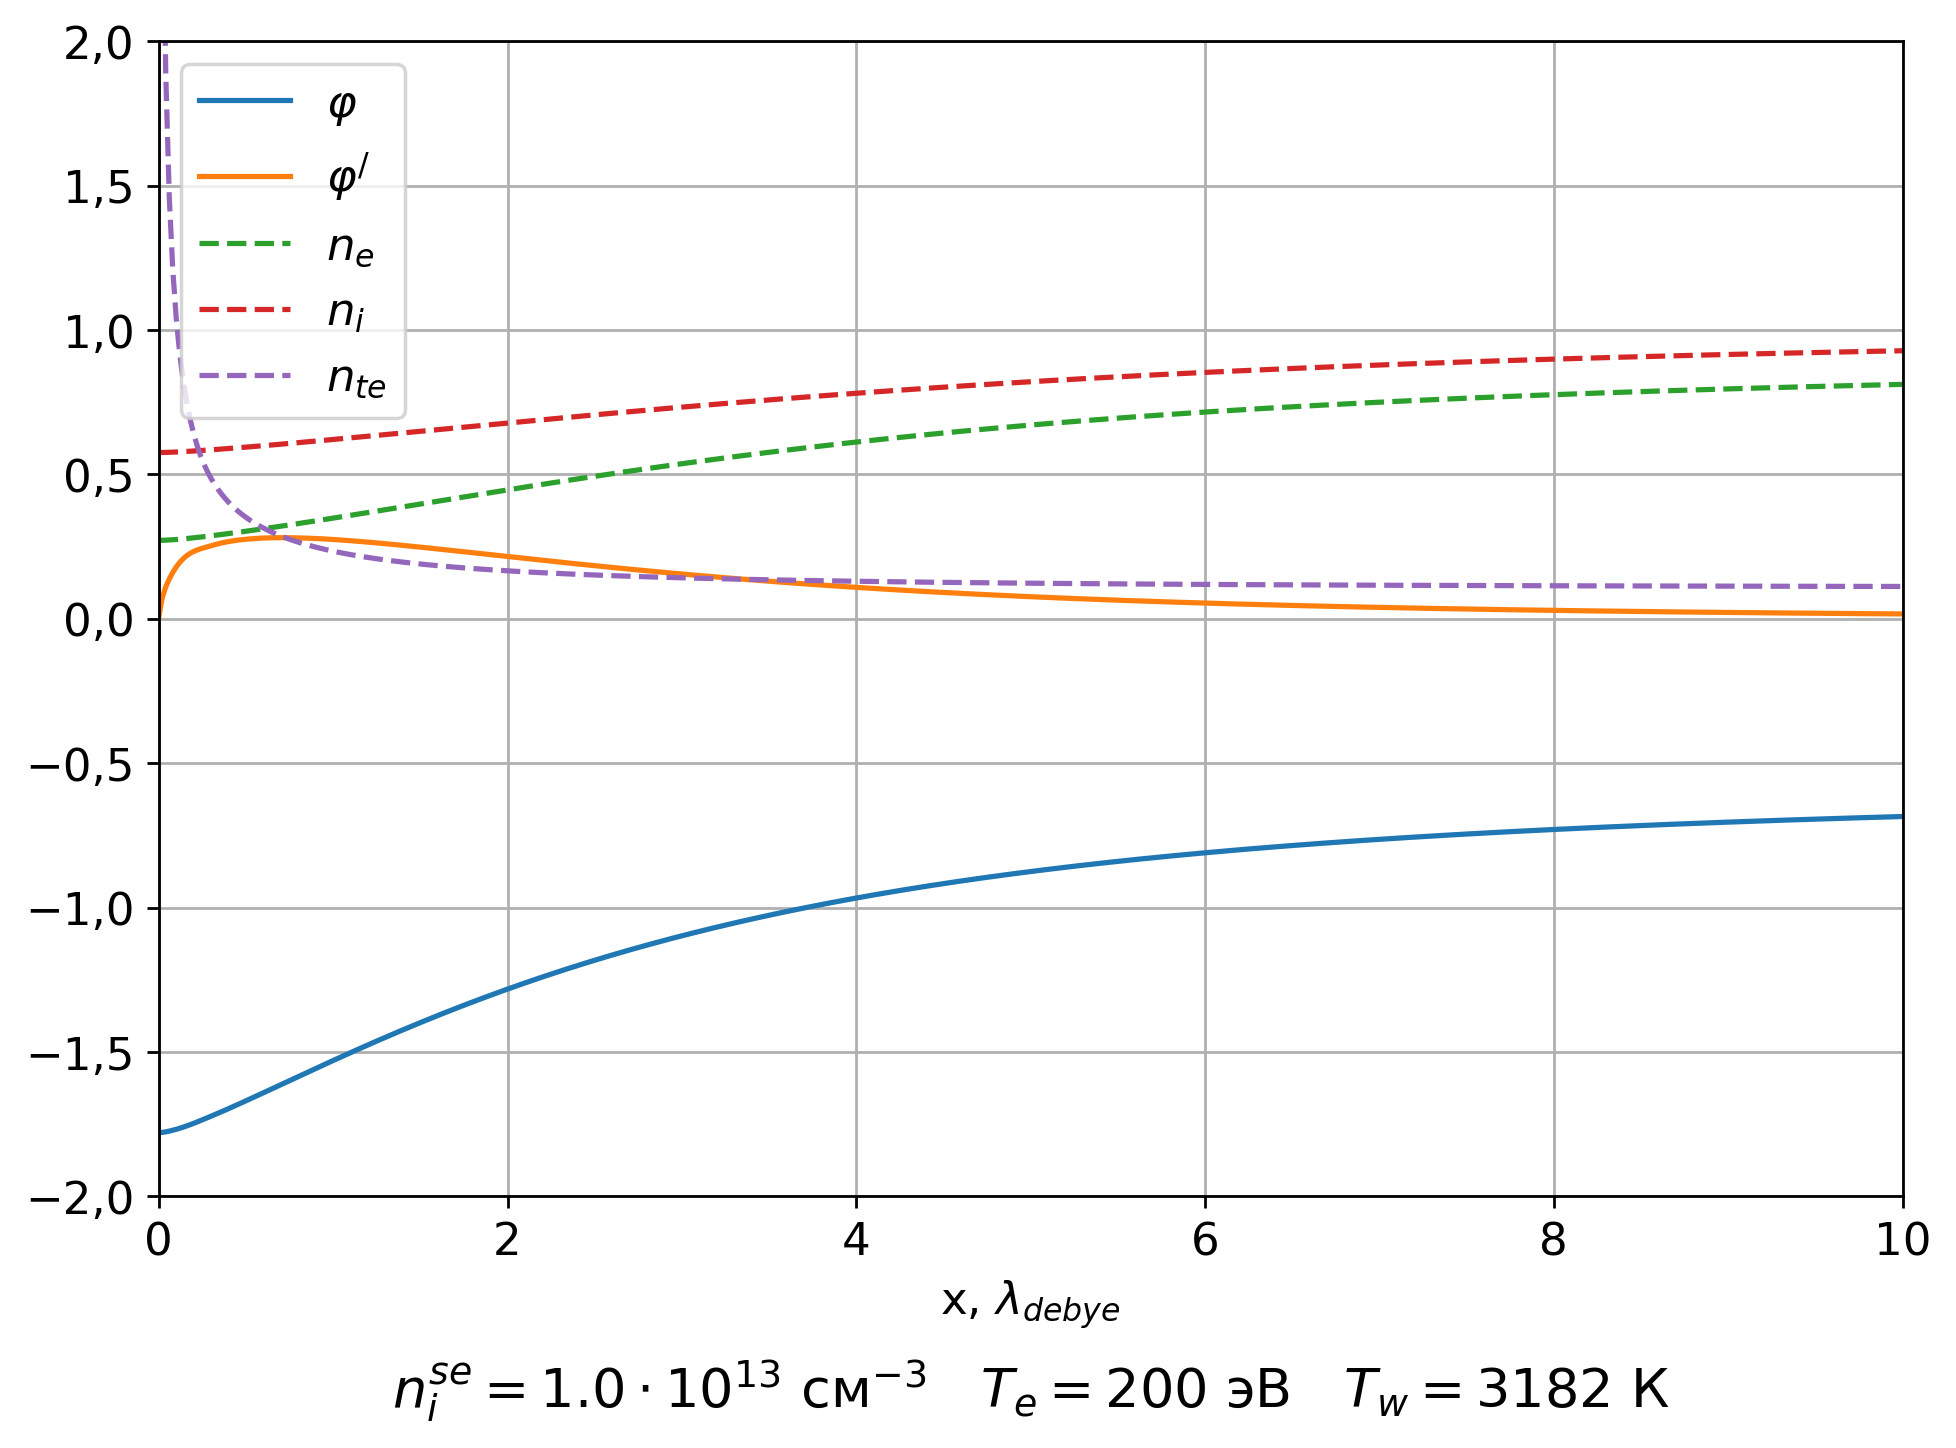

In [44]:
x_net_rigorous = np.linspace(0, xmax_rigorous, x_net_steps_rigorous)
x_net_sparse = np.linspace(xmax_rigorous, xmax_sparse, x_net_steps_sparse)
x_net = np.concatenate((x_net_rigorous, x_net_sparse[1:]))
x_net_steps = np.shape(x_net)[0]
plt.xlim(0, xmax_sparse)
plt.ylim(-2.0, 2.0)
plt.plot(x_net, E_field_guess[0], label = r"$\varphi$")
plt.plot(x_net, E_field_guess[1], label = r"$\varphi^/$")
plt.grid()
plt.legend()
plt.show()
print(E_field_guess[1, 0])
fig = plt.figure(figsize = (9, 6), dpi = 250)
plt.xlim(0, xmax_plot)
plt.ylim(-2.0, 2.0)
plt.plot(x_net_plot, SCL_dist_plot[0], label = r"$\varphi$")
plt.plot(x_net_plot, SCL_dist_plot[1], label = r"$\varphi^/$")
plt.plot(x_net_plot, SCL_dist_plot[2], linestyle = "--", label = r"$n_e$")
plt.plot(x_net_plot, SCL_dist_plot[3], linestyle = "--", label = r"$n_i$")
plt.plot(x_net_plot, SCL_dist_plot[4], linestyle = "--", label = r"$n_{te}$")
plt.title(
	r"$n_i^{se} = %.1f\cdot10^{%d}$ см$^{-3}$   "
    r"$T_e = %0.f$ эВ   "
    r"$T_w = %0.f$ К"
    % (nse / 10 ** floor(log10(nse)), floor(log10(nse)), Te * erg_to_eV, TK(Tw_SCL_net[SCL_dist_plot_num])),
	y = -0.2)
plt.xlabel(r"x, $\lambda_{debye}$")
plt.legend()
plt.grid()
plt.show()